In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
#data1=pd.read_csv('Airtel - Adhoc Data Classification.csv')
data=pd.read_excel('airtel_1.xlsx')
data.head()

,Unnamed: 0,DATE,TIMESTAMP,SOURCE_MSISDN,DESTINATION_MSISDN,SMS,language_secondary,class_predictions,operator
0,0,20200110,20200110163549,919205957413,-1,Airtel Welcomes you,english,Others,NaN
1,1,20200110,20200110163704,919205957413,-1,ಈಗ ನಿಮ್ಮ ರಿಜಿಸ್ಟರ್ಡ್ ಟೆಲಿಫೋನ್ ನಂಬರ್ ನಿಂದ ಮಿಸ್ ...,kannada,NaN,NaN
2,2,20200111,20200111103146,AY-650002,-1,Rs219 mein payein Unlimited call sabhi network...,hinglish,Promotion,NaN
3,3,20200112,20200112104509,AY-650003,-1,Rs149 mein payein Unlimited call sabhi network...,hinglish,Promotion,NaN
4,4,20200113,20200113124039,AY-650003,-1,Unlimited call sabhi network par aur 6GB data ...,hinglish,Promotion,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 9 columns):
Unnamed: 0            1490 non-null int64
DATE                  1490 non-null int64
TIMESTAMP             1490 non-null int64
SOURCE_MSISDN         1490 non-null object
DESTINATION_MSISDN    1490 non-null int64
SMS                   1490 non-null object
language_secondary    1490 non-null object
class_predictions     1342 non-null object
operator              1193 non-null object
dtypes: int64(4), object(5)
memory usage: 104.8+ KB


In [4]:
indexes=list(data.loc[data['class_predictions'].isnull(),:].index)
data=data.drop(indexes,axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1342 entries, 0 to 1489
Data columns (total 9 columns):
Unnamed: 0            1342 non-null int64
DATE                  1342 non-null int64
TIMESTAMP             1342 non-null int64
SOURCE_MSISDN         1342 non-null object
DESTINATION_MSISDN    1342 non-null int64
SMS                   1342 non-null object
language_secondary    1342 non-null object
class_predictions     1342 non-null object
operator              1063 non-null object
dtypes: int64(4), object(5)
memory usage: 104.8+ KB


In [5]:
print(data['language_secondary'].unique())

['english' 'hinglish' 'benglish']


In [6]:
new=data.loc[data['class_predictions']=='Promotion',:]
print(new['language_secondary'].unique())

['hinglish' 'english' 'benglish']


In [7]:
print(data['class_predictions'].unique()) 

['Others' 'Promotion' 'Rechargeconfirmation' 'OthersRoaming'
 'Barringalert' 'Postexpiryalert' 'Preexpiryalert' 'Datausagealert']


# Cleaning

In [149]:
def cleaning(text):
    text=text.lower()
    text=re.sub('\[.*?\]',' ',text)
    text=re.sub('\d*[()]',' ',text)
    text=re.sub('[%s]' %re.escape(string.punctuation),' ',text)
    text=re.sub('[''""...]',' ',text)
    text=re.sub(' \d ',' ',text)
    text=re.sub(' \w ',' ',text)
    text=re.sub('\n','',text)
    text=re.sub('click','',text)
    text=re.sub('http','',text)
    text=re.sub('https','',text)
    text=text.split('bit')[0]
    text=re.sub('ul',' unlimited ',text)
    text=re.sub('rchg',' recharge ',text)
    text=re.sub('calls',' call ',text)
    text=re.sub('  ',' ',text)
    text=re.sub('121','',text)
    text=re.sub('28d',' 28 din ',text)
    text=re.sub('56d',' 56 din ',text)
    text=re.sub('84d',' 84 din ',text)
    return text
round1=lambda x:cleaning(x)

In [150]:
data['SMS_clean']=data['SMS'].apply(round1)

In [151]:
print(data['SMS'][408],'\n',data['SMS_clean'][408])

Vodafone er Special recharge1)Rs599=3GB/D+ UL calls-84D2)Rs249=3GB/D+ UL calls-28DAaj e recharge Korun 
 vodafone er special recharge rs599 3gb  unlimited  call  84 din  rs249 3gb  unlimited  call  28 din aaj recharge korun


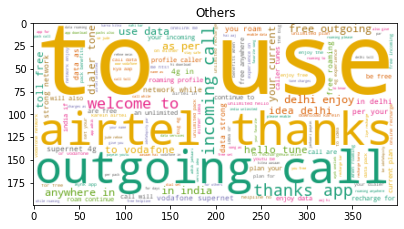

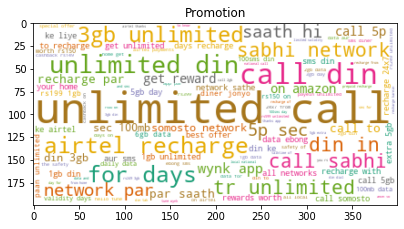

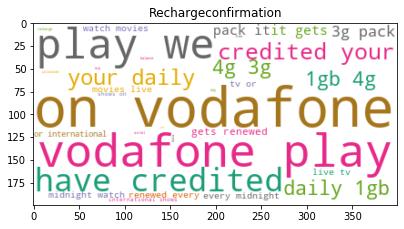

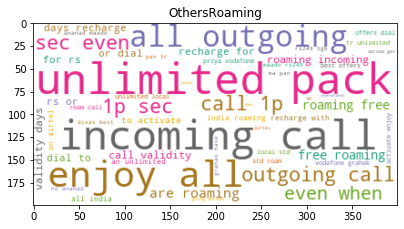

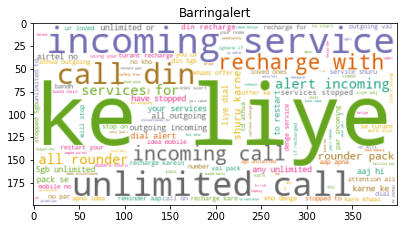

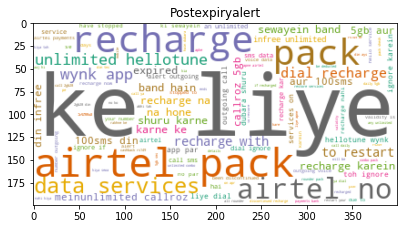

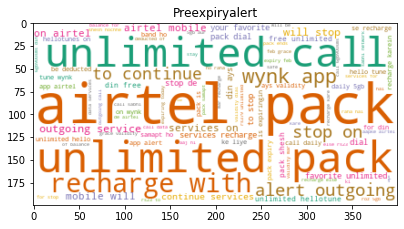

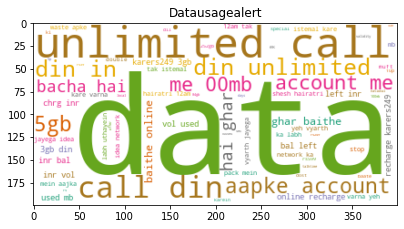

In [152]:
#using wordclouds to see most frequent word occurences
plt.rcParams['figure.figsize']=30,25
wc=WordCloud(background_color='white',colormap='Dark2',max_font_size=150,random_state=42)
a=list(data['class_predictions'].unique())
for i in a:
    plt.subplot(2,4,a.index(i)+1)
    new=data.loc[data['class_predictions']==i,:]
    new.index=range(new.shape[0])
    b=new['SMS_clean'][0]
    for j in range(1,new.shape[0]):
        b+=' '+new['SMS_clean'][j]
    wc.generate(b)    
    plt.imshow(wc,interpolation='bilinear')
    plt.title(i)
    plt.show()    


In [153]:
print(data['class_predictions'].unique())

['Others' 'Promotion' 'Rechargeconfirmation' 'OthersRoaming'
 'Barringalert' 'Postexpiryalert' 'Preexpiryalert' 'Datausagealert']


In [154]:
vec=CountVectorizer(max_features=10)
data_promotion=data.loc[data['class_predictions']=='Datausagealert',:]
dtm=vec.fit_transform(data_promotion['SMS_clean'])
result=pd.DataFrame(dtm.toarray(),columns=vec.get_feature_names())
print(result.head(30))

    28  bacha  call  data  din  hai  in  inr  mb  unlimited
0    0      0     0     3    0    0   0    0   1          0
1    0      0     0     3    0    0   0    0   1          0
2    0      0     0     3    0    0   0    0   1          0
3    0      0     0     3    0    0   0    0   1          0
4    1      1     1     1    2    1   1    0   0          1
5    1      1     1     1    2    1   1    0   0          1
6    1      1     1     1    2    1   1    0   0          1
7    0      0     1     3    1    0   0    2   1          1
8    1      1     1     1    2    1   1    0   0          1
9    1      1     1     1    2    1   1    0   0          1
10   1      1     1     1    2    1   1    0   0          1
11   1      0     1     3    1    0   0    2   1          1
12   0      0     1     1    0    0   0    2   1          0
13   1      0     1     3    4    0   1    2   1          1
14   1      0     1     2    0    0   0    2   1          1
15   0      0     1     1    0    0   0 

In [155]:
def get_most_frequent_words(data):
    a=list(data['class_predictions'].unique())
    for i in a:
        plt.rcParams['figure.figsize']=40,10
        sum1=[]
        new=data.loc[data['class_predictions']==i,:]
        dtm=vec.fit_transform(new['SMS_clean'])
        result=pd.DataFrame(dtm.toarray(),columns=vec.get_feature_names())
        for j in result.columns:
            sum1.append(result[j].sum())
        plt.subplot(2,4,a.index(i)+1)
        plt.scatter(vec.get_feature_names(),sum1)
        plt.title(i)
        plt.show()
    return plt.show()
            

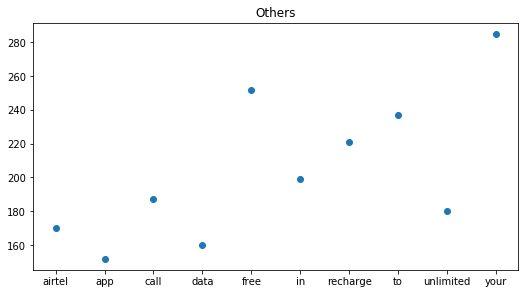

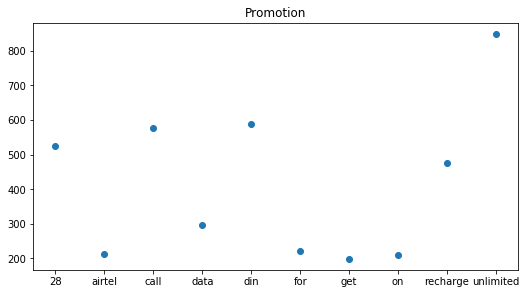

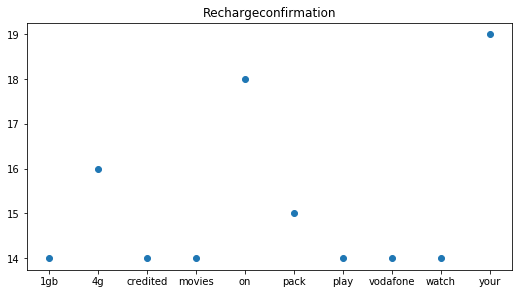

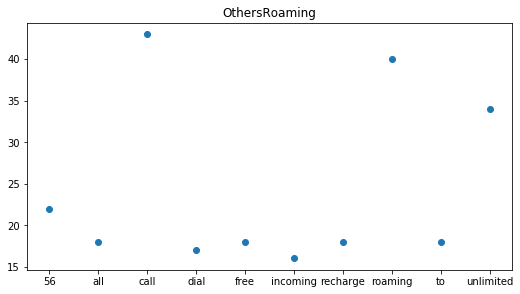

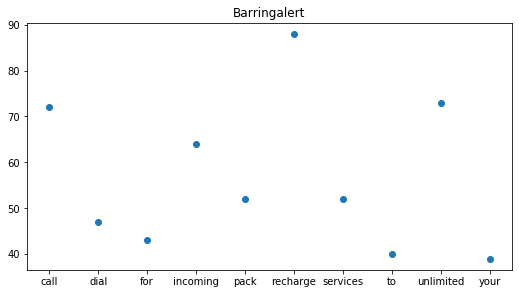

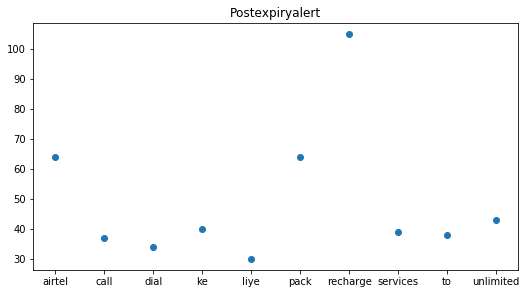

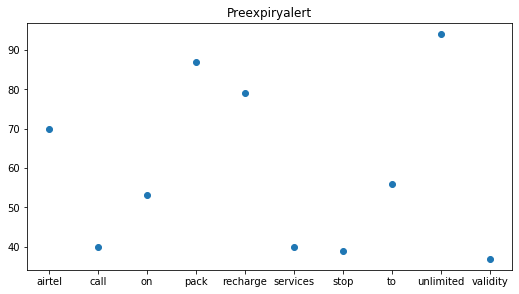

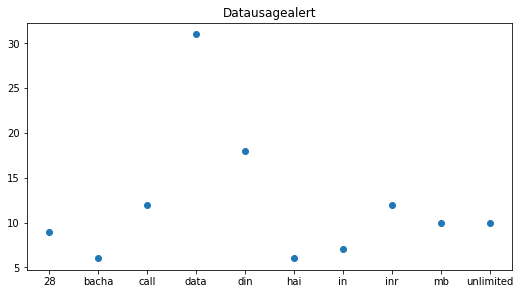

In [156]:
get_most_frequent_words(data)

In [157]:
#using count vectorizer
vec=CountVectorizer(max_features=50)
dtm=vec.fit_transform(data['SMS_clean'])
x=pd.DataFrame(dtm.toarray(),columns=vec.get_feature_names())
y=data['class_predictions']
le=LabelEncoder()
y=le.fit_transform(y)
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,train_size=0.9,random_state=100)

In [158]:
#labels and their corresponding class
values=np.arange(8)
classes=le.inverse_transform(values)
labels_encoded=pd.DataFrame({'labels':values,'class':classes})
print(labels_encoded)

   labels                 class
0       0          Barringalert
1       1        Datausagealert
2       2                Others
3       3         OthersRoaming
4       4       Postexpiryalert
5       5        Preexpiryalert
6       6             Promotion
7       7  Rechargeconfirmation


In [159]:
x.head()

,1gb,28,2gb,3gb,4g,5gb,84,airtel,all,and,...,services,sms,to,unlimited,validity,vodafone,with,wynk,you,your
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
2,0,1,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
3,0,0,0,0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,2,1,0,1,0,0,2,2


In [160]:
rf=RandomForestClassifier(max_depth=7,max_features=40,n_estimators=500,criterion='gini',min_samples_leaf=3)
rf.fit(x_train,y_train)
predict=rf.predict(x_test)
proba=rf.predict_proba(x_test)
print('accuracy:',sklearn.metrics.accuracy_score(y_test,predict),'log_loss:',sklearn.metrics.log_loss(y_test,proba))

accuracy: 0.8888888888888888 log_loss: 0.4043726247709985


In [161]:
xgb=XGBClassifier(max_depth=7,learning_rate=0.005,n_estimators=500,
                 min_child_weight=3,colsample_bytree=0.8,gamma=3,reg_lambda=0,seed=42)
xgb.fit(x_train,y_train)
predict=xgb.predict(x_test)
proba=xgb.predict_proba(x_test)
print('accuracy:',sklearn.metrics.accuracy_score(y_test,predict),'log_loss:',sklearn.metrics.log_loss(y_test,proba))

accuracy: 0.9259259259259259 log_loss: 0.44292086881619913


In [162]:
labels=[]
for i in range(proba.shape[0]):
    a=list(proba[i])
    maximum=max(a)
    labels.append(a.index(maximum))
print(labels)    

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 4, 2, 6, 6, 2, 6, 2, 6, 5, 4, 6, 6, 6, 2, 2, 2, 6, 0, 6, 2, 0, 2, 2, 1, 2, 6, 4, 6, 2, 3, 2, 2, 2, 2, 6, 6, 6, 6, 2, 2, 6, 6, 6, 5, 6, 6, 2, 6, 4, 4, 6, 6, 2, 6, 0, 6, 4, 6, 6, 2, 2, 5, 4, 6, 5, 6, 6, 2, 2, 6, 6, 6, 6, 0, 2, 6, 2, 6, 3, 5, 5, 2, 0, 2, 2, 2, 6, 6, 0, 6, 6, 2, 6, 6, 6, 2, 5, 6, 2, 2, 0, 2, 5, 2, 2, 2, 2, 2, 5, 6, 6, 2, 3, 5, 6, 2, 6, 6, 6, 6, 5, 5]


In [163]:
print(y_test)

[6 6 6 6 6 6 6 6 6 6 0 6 6 4 2 6 3 2 6 2 6 5 4 6 6 6 2 5 2 6 0 6 2 0 2 2 1
 2 2 4 6 2 3 2 7 2 2 6 6 6 6 2 2 6 6 6 4 6 6 2 6 4 4 6 6 2 7 0 6 4 6 6 2 2
 4 4 6 6 6 6 2 2 6 6 6 6 0 2 6 2 6 6 5 5 2 0 2 2 2 6 1 0 6 6 2 6 6 6 2 5 6
 2 2 0 2 5 2 2 2 2 2 5 6 6 2 3 5 6 2 6 6 6 6 5 5]


In [164]:
print(len(y_test),len(labels))

135 135


In [165]:
#accuracy of predicting class Promotion
labels=np.array(labels)
index=np.where(y_test==6)[0]
labels=labels[index]
true_positive=[]
for i in labels:
    if i==6:
        true_positive.append(1)
print('accuracy_for_0:',len(true_positive)/len(index))        

accuracy_for_0: 0.9672131147540983


In [166]:
print(labels)

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 5 6 6 6 6 6 6 6 6 3 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [167]:
#using tfidf
tfidf=TfidfVectorizer(max_features=50)
dtm=tfidf.fit_transform(data['SMS_clean'])
x=pd.DataFrame(dtm.toarray(),columns=tfidf.get_feature_names())
y=data['class_predictions']
le=LabelEncoder()
y=le.fit_transform(y)
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,train_size=0.9,random_state=100)

In [168]:
x.head()

,1gb,28,2gb,3gb,4g,5gb,84,airtel,all,and,...,services,sms,to,unlimited,validity,vodafone,with,wynk,you,your
0,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.551688,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.834050,0.000000
1,0.225681,0.151399,0.0000,0.0,0.000000,0.0,0.000000,0.149847,0.0,0.0,...,0.0,0.237734,0.000000,0.110522,0.0,0.000000,0.0,0.245141,0.000000,0.000000
2,0.000000,0.155308,0.2465,0.0,0.000000,0.0,0.000000,0.153717,0.0,0.0,...,0.0,0.000000,0.000000,0.113376,0.0,0.000000,0.0,0.251471,0.000000,0.000000
3,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.235782,0.150491,0.0,0.0,...,0.0,0.000000,0.000000,0.110997,0.0,0.000000,0.0,0.246194,0.000000,0.000000
4,0.000000,0.000000,0.0000,0.0,0.196042,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.254096,0.086966,0.0,0.171816,0.0,0.000000,0.356515,0.279944


In [169]:
rf=RandomForestClassifier(max_depth=7,max_features=40,n_estimators=500,criterion='gini',min_samples_leaf=3)
rf.fit(x_train,y_train)
predict=rf.predict(x_test)
proba=rf.predict_proba(x_test)
print('accuracy:',sklearn.metrics.accuracy_score(y_test,predict),'log_loss:',sklearn.metrics.log_loss(y_test,proba))

accuracy: 0.8888888888888888 log_loss: 0.36231209742293125


In [170]:
xgb=XGBClassifier(max_depth=7,learning_rate=0.005,n_estimators=500,
                 min_child_weight=3,colsample_bytree=0.8,gamma=3,reg_lambda=0,seed=42)
xgb.fit(x_train,y_train)
predict=xgb.predict(x_test)
proba=xgb.predict_proba(x_test)
print('accuracy:',sklearn.metrics.accuracy_score(y_test,predict),'log_loss:',sklearn.metrics.log_loss(y_test,proba))

accuracy: 0.9407407407407408 log_loss: 0.3921496187095289


In [171]:
labels=[]
for i in range(proba.shape[0]):
    a=list(proba[i])
    maximum=max(a)
    labels.append(a.index(maximum))

#accuracy of predicting class Promotion
labels=np.array(labels)
index=np.where(y_test==6)[0]
labels=labels[index]
true_positive=[]
for i in labels:
    if i==6:
        true_positive.append(1)
print('accuracy_for_6:',len(true_positive)/len(index))        

accuracy_for_6: 1.0


In [172]:
index=np.where(y_test==6)[0]
test=y_test[index]
print(test,'\n',labels)

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6] 
 [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [173]:
def get_mrp(text):
    p1=re.compile(' rs\d+ ')
    p2=p1.findall(text)
    p3=re.compile(' \d+9 ')
    p4=p3.findall(text)
    return p2,p4

In [174]:
y=get_mrp(data['SMS_clean'][53])
print(y)

([' rs249 ', ' rs599 '], [])
